In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [8]:
FILE_PAIRS = {
    "cbench": {
        "x86_64": "cbench_results_x86_64.csv",
        "arm64": "cbench_results_arm64.csv"
    },
    "mibench": {
        "x86_64": "mibench_results_x86_64.csv",
        "arm64": "mibench_results_arm64.csv"
    }
}

In [13]:
Path("plots").mkdir(exist_ok=True)

In [9]:
def load_and_clean_data(filepath):
    """Загружает CSV и убирает строки с ошибками."""
    if not Path(filepath).exists():
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл {filepath} не найден. Пропускаем...")
        return None
    df = pd.read_csv(filepath)
    
    # Определяем последний столбец как столбец с ускорением
    speedup_col = df.columns[-1]
    
    # Убираем строки, где время или ускорение записаны как "ERROR"
    df = df[df[speedup_col] != "ERROR"].copy()
    df[speedup_col] = pd.to_numeric(df[speedup_col])
    
    # Убираем строки с NaN или бесконечными значениями на всякий случай
    df.dropna(subset=[speedup_col], inplace=True)
    df = df[pd.notna(df[speedup_col])]
    
    return df

In [10]:
def plot_correlation(benchmark_name, suite_name, df_x86, df_arm, flag_cols, speedup_col):
    """Строит диаграмму рассеяния для сравнения производительности."""
    
    merged_df = pd.merge(
        df_x86[['benchmark'] + flag_cols + [speedup_col]],
        df_arm[['benchmark'] + flag_cols + [speedup_col]],
        on=['benchmark'] + flag_cols,
        suffixes=('_x86', '_arm')
    )
    
    if merged_df.empty:
        return

    speedup_col_x86 = speedup_col + '_x86'
    speedup_col_arm = speedup_col + '_arm'

    best_x86_run = merged_df.loc[merged_df[speedup_col_x86].idxmax()]
    best_arm_run = merged_df.loc[merged_df[speedup_col_arm].idxmax()]

    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=merged_df, x=speedup_col_x86, y=speedup_col_arm, alpha=0.3, label='Все комбинации')
    
    # Добавляем диагональную линию y=x для ориентира
    lims = [
        min(plt.xlim()[0], plt.ylim()[0]),
        max(plt.xlim()[1], plt.ylim()[1]),
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='y=x (идеальная переносимость)')

    # Выделяем лучшие точки
    plt.scatter(best_x86_run[speedup_col_x86], best_x86_run[speedup_col_arm], 
                color='red', s=150, edgecolor='black', zorder=5, label=f'Лучшая для x86 (ускорение {best_x86_run[speedup_col_x86]:.2f}x)')
    plt.scatter(best_arm_run[speedup_col_x86], best_arm_run[speedup_col_arm], 
                color='green', s=150, edgecolor='black', zorder=5, label=f'Лучшая для ARM (ускорение {best_arm_run[speedup_col_arm]:.2f}x)')

    plt.title(f'Корреляция ускорений для "{benchmark_name}" ({suite_name})')
    plt.xlabel('Ускорение на x86_64 (относительно -O3)')
    plt.ylabel('Ускорение на arm64 (относительно -O3)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Создаем поддиректорию для каждого набора
    plot_dir = Path(f"plots/{suite_name}")
    plot_dir.mkdir(exist_ok=True, parents=True)
    plt.savefig(plot_dir / f"{benchmark_name}_correlation.png")
    plt.show()
    plt.close()

In [ ]:
def analyze_suite(suite_name, files):
    """Проводит полный анализ для одного набора бенчмарков (cbench или mibench)."""
    print(f"\n{'='*20} АНАЛИЗ НАБОРА: {suite_name.upper()} {'='*20}")

    df_x86 = load_and_clean_data(files["x86_64"])
    df_arm = load_and_clean_data(files["arm64"])

    if df_x86 is None or df_arm is None:
        return

    flag_cols = df_x86.columns[1:-2].tolist()
    speedup_col = df_x86.columns[-1]

    benchmarks = sorted(list(set(df_x86['benchmark'].unique()) & set(df_arm['benchmark'].unique())))
    
    total_benchmarks = len(benchmarks)
    matches = 0
    
    for benchmark_name in benchmarks:
        print(f"\n--- Анализ бенчмарка: {benchmark_name} ---")

        bench_x86 = df_x86[df_x86['benchmark'] == benchmark_name].copy()
        bench_arm = df_arm[df_arm['benchmark'] == benchmark_name].copy()

        if bench_x86.empty or bench_arm.empty:
            continue

        # 1. Прямое сравнение
        best_x86_run = bench_x86.loc[bench_x86[speedup_col].idxmax()]
        best_arm_run = bench_arm.loc[bench_arm[speedup_col].idxmax()]

        best_x86_flags = best_x86_run[flag_cols]
        best_arm_flags = best_arm_run[flag_cols]

        flags_match = best_x86_flags.equals(best_arm_flags)
        if flags_match:
            matches += 1
            print("  [+] Оптимальные комбинации флагов СОВПАЛИ.")
        else:
            print("  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.")

        # 2. Оценка стоимости переноса и анализ рангов
        best_x86_speedup = best_x86_run[speedup_col]
        best_arm_speedup = best_arm_run[speedup_col]

        # Добавляем ранги для ARM
        bench_arm['rank'] = bench_arm[speedup_col].rank(method='min', ascending=False).astype(int)
        
        # Теперь ищем производительность лучшей x86-комбинации в данных ARM
        # merged_arm теперь будет содержать столбец 'rank'
        merged_arm = pd.merge(bench_arm, best_x86_flags.to_frame().T, on=flag_cols, how='inner')
        
        if not merged_arm.empty:
            arm_perf_with_x86_flags = merged_arm.iloc[0][speedup_col]
            loss_on_arm = (1 - arm_perf_with_x86_flags / best_arm_speedup) * 100
            print(f"    - Перенос x86 -> ARM: Потеря производительности {loss_on_arm:.2f}% (Ускорение {arm_perf_with_x86_flags:.4f}x вместо {best_arm_speedup:.4f}x)")
            
            # Теперь эта строка будет работать
            rank_of_x86_best_on_arm = merged_arm.iloc[0]['rank']
            print(f"    - Ранг лучшей x86-комбинации на ARM: {rank_of_x86_best_on_arm} из {len(bench_arm)}")
        else:
            print("    - Не удалось найти соответствующую x86-комбинацию в данных ARM.")

        # То же самое для переноса ARM -> x86
        bench_x86['rank'] = bench_x86[speedup_col].rank(method='min', ascending=False).astype(int)
        merged_x86 = pd.merge(bench_x86, best_arm_flags.to_frame().T, on=flag_cols, how='inner')
        
        if not merged_x86.empty:
            x86_perf_with_arm_flags = merged_x86.iloc[0][speedup_col]
            loss_on_x86 = (1 - x86_perf_with_arm_flags / best_x86_speedup) * 100
            print(f"    - Перенос ARM -> x86: Потеря производительности {loss_on_x86:.2f}% (Ускорение {x86_perf_with_arm_flags:.4f}x вместо {best_x86_speedup:.4f}x)")
            
            rank_of_arm_best_on_x86 = merged_x86.iloc[0]['rank']
            print(f"    - Ранг лучшей ARM-комбинации на x86: {rank_of_arm_best_on_x86} из {len(bench_x86)}")
        else:
            print("    - Не удалось найти соответствующую ARM-комбинацию в данных x86.")


        # 4. Визуализация
        plot_correlation(benchmark_name, suite_name, bench_x86, bench_arm, flag_cols, speedup_col)

    print(f"\n--- Итоги по набору {suite_name.upper()} ---")
    print(f"Всего проанализировано бенчмарков: {total_benchmarks}")
    print(f"Количество полных совпадений оптимальных флагов: {matches} ({matches/total_benchmarks:.1%})")
    print(f"Вывод: Гипотеза о непереносимости в целом {'ПОДТВЕРЖДАЕТСЯ' if matches < total_benchmarks else 'ОПРОВЕРГАЕТСЯ'}.")
    print(f"Графики сохранены в директорию 'plots/'.")



==================== АНАЛИЗ НАБОРА: CBENCH ====================

--- Анализ бенчмарка: cat-cat1 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 0.69% (Ускорение 1.0102x вместо 1.0172x)
    - Ранг лучшей x86-комбинации на ARM: 179 из 256
    - Перенос ARM -> x86: Потеря производительности 5.30% (Ускорение 1.0004x вместо 1.0564x)
    - Ранг лучшей ARM-комбинации на x86: 241 из 256


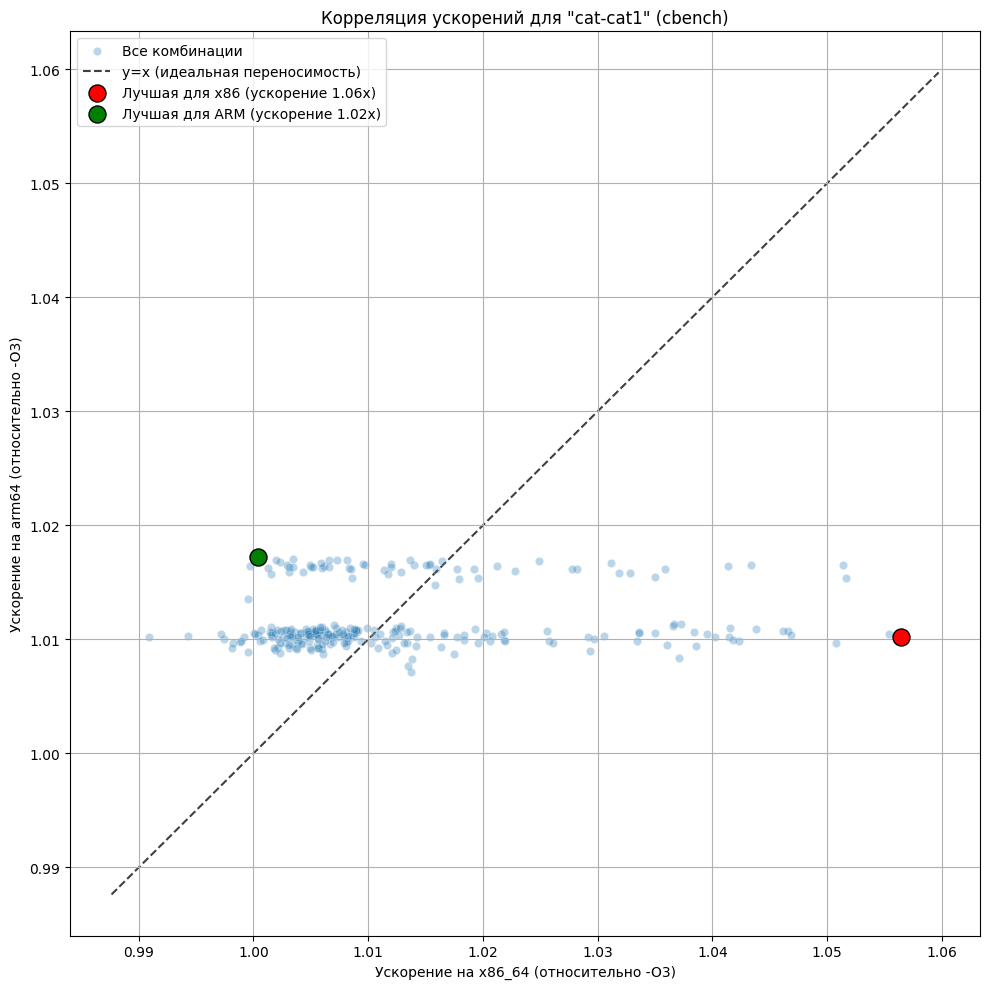


--- Анализ бенчмарка: cat-cat2 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 19.73% (Ускорение 0.9904x вместо 1.2339x)
    - Ранг лучшей x86-комбинации на ARM: 99 из 256
    - Перенос ARM -> x86: Потеря производительности 21.46% (Ускорение 0.9217x вместо 1.1736x)
    - Ранг лучшей ARM-комбинации на x86: 253 из 256


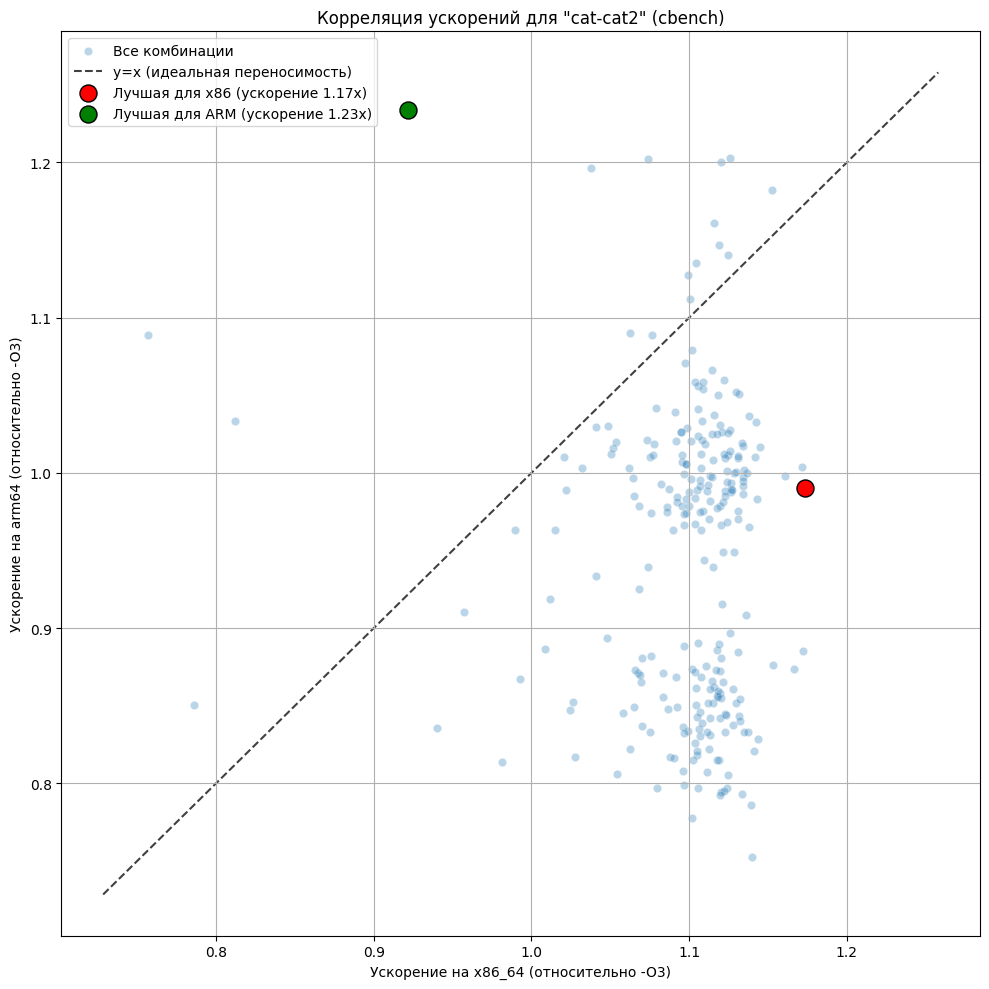


--- Анализ бенчмарка: cat-cat3 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 19.98% (Ускорение 0.9523x вместо 1.1901x)
    - Ранг лучшей x86-комбинации на ARM: 82 из 256
    - Перенос ARM -> x86: Потеря производительности 4.83% (Ускорение 0.9594x вместо 1.0081x)
    - Ранг лучшей ARM-комбинации на x86: 137 из 256


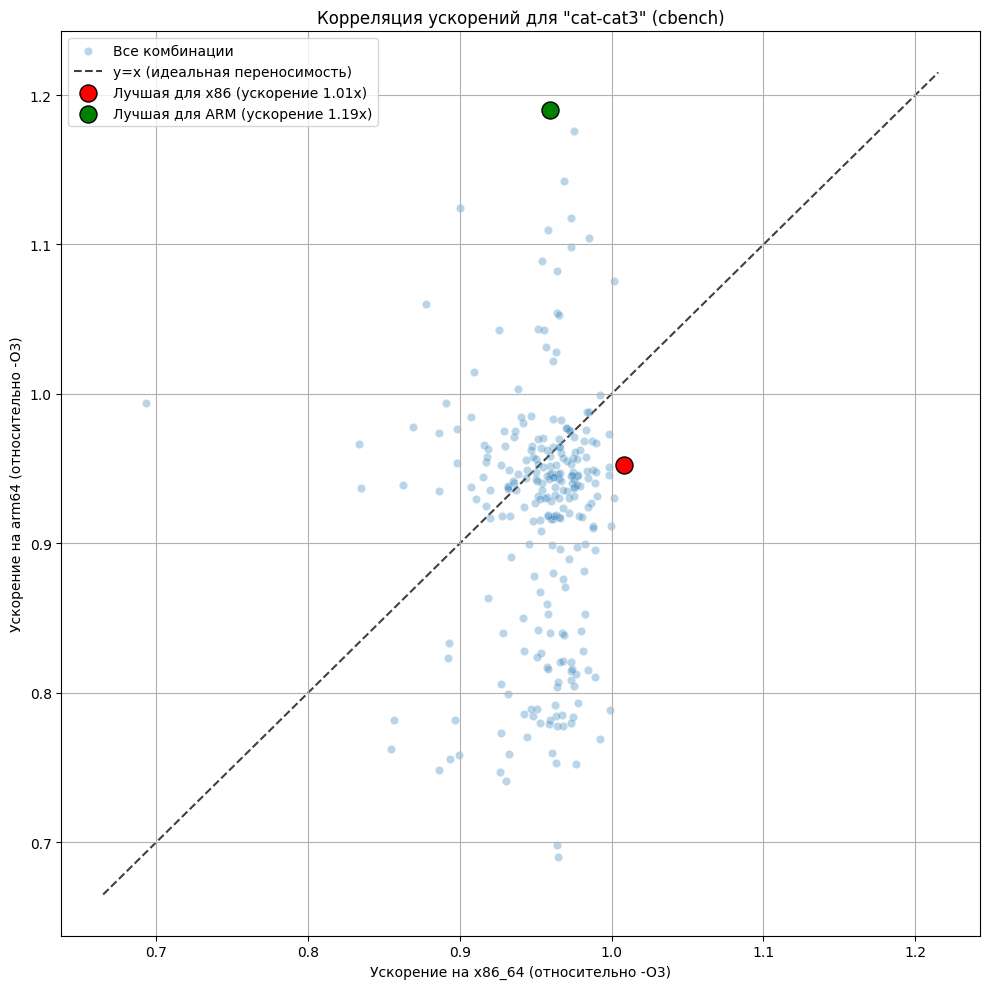


--- Анализ бенчмарка: fac-fac1 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 15.49% (Ускорение 1.0351x вместо 1.2248x)
    - Ранг лучшей x86-комбинации на ARM: 82 из 256
    - Перенос ARM -> x86: Потеря производительности 0.12% (Ускорение 1.1666x вместо 1.1680x)
    - Ранг лучшей ARM-комбинации на x86: 2 из 256


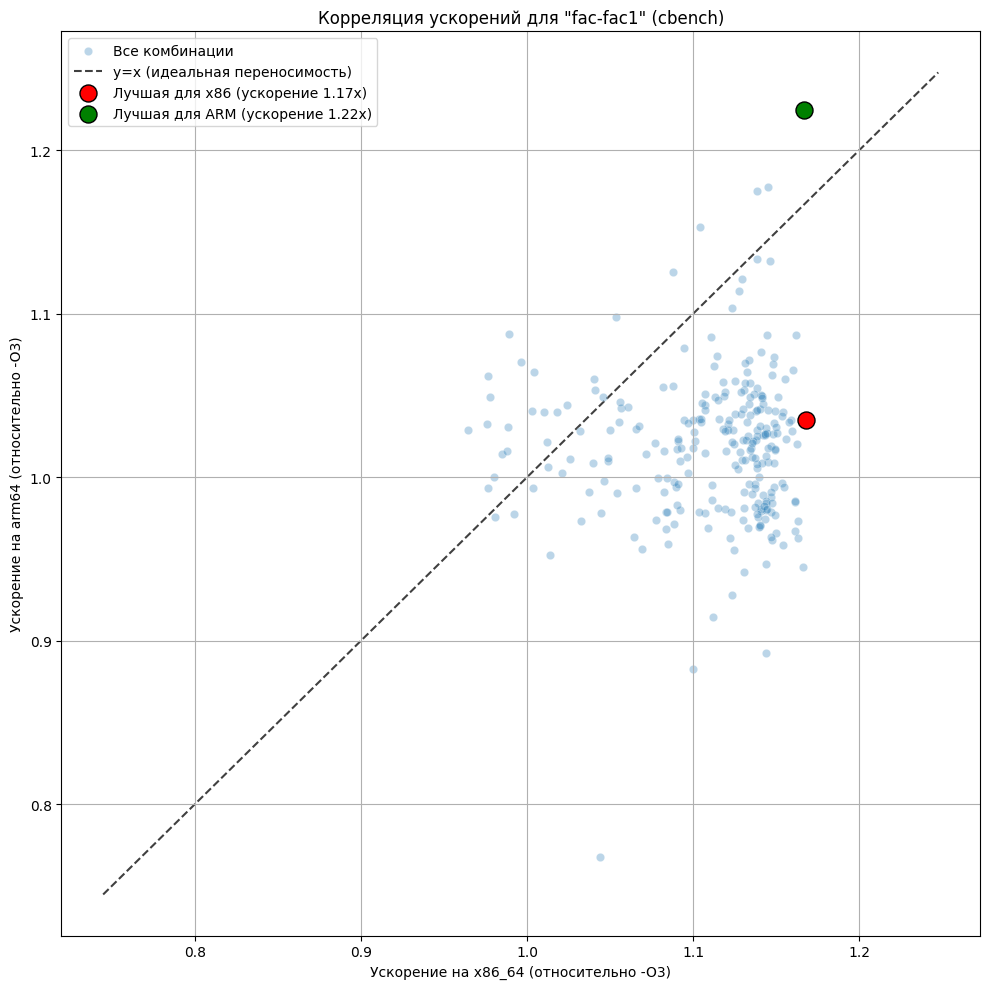


--- Анализ бенчмарка: fac-fac2 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 14.73% (Ускорение 1.0481x вместо 1.2292x)
    - Ранг лучшей x86-комбинации на ARM: 45 из 256
    - Перенос ARM -> x86: Потеря производительности 2.94% (Ускорение 0.9976x вместо 1.0278x)
    - Ранг лучшей ARM-комбинации на x86: 112 из 256


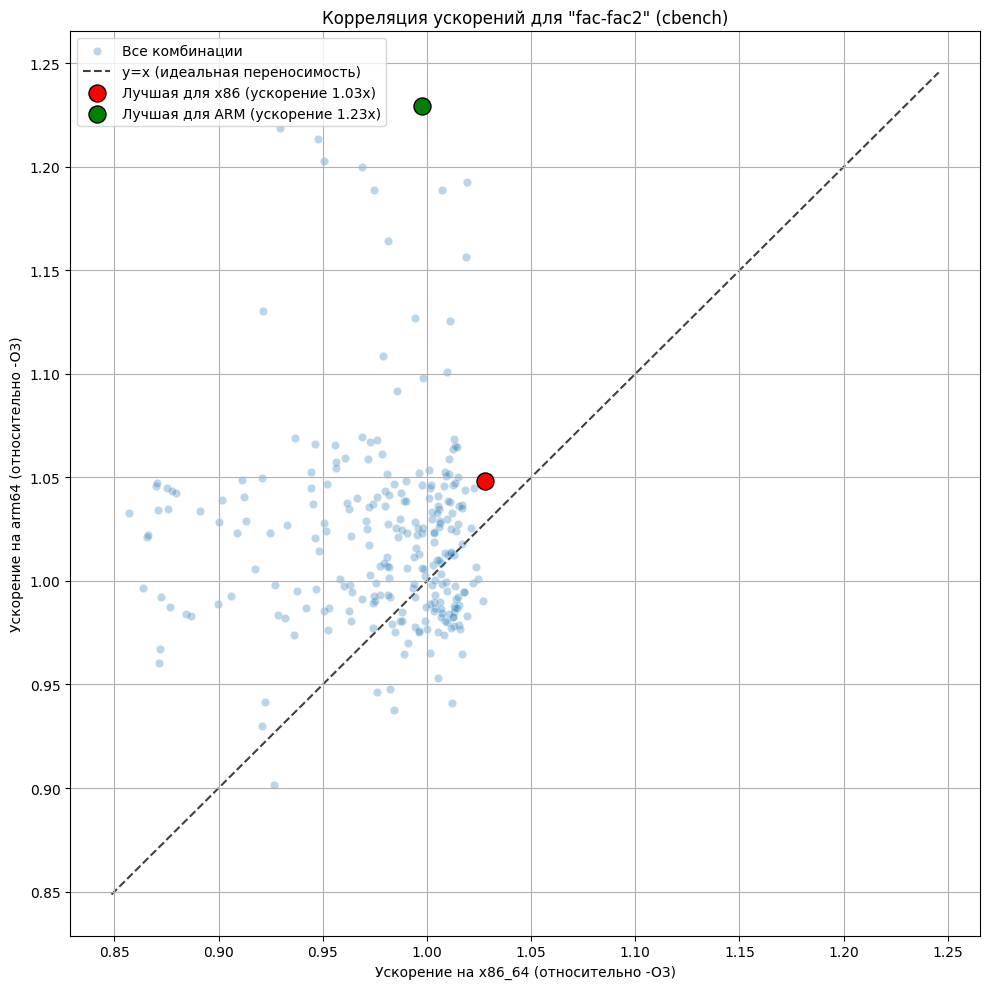


--- Анализ бенчмарка: fac-fac3 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 20.19% (Ускорение 0.9712x вместо 1.2169x)
    - Ранг лучшей x86-комбинации на ARM: 223 из 256
    - Перенос ARM -> x86: Потеря производительности 4.58% (Ускорение 0.9619x вместо 1.0080x)
    - Ранг лучшей ARM-комбинации на x86: 152 из 256


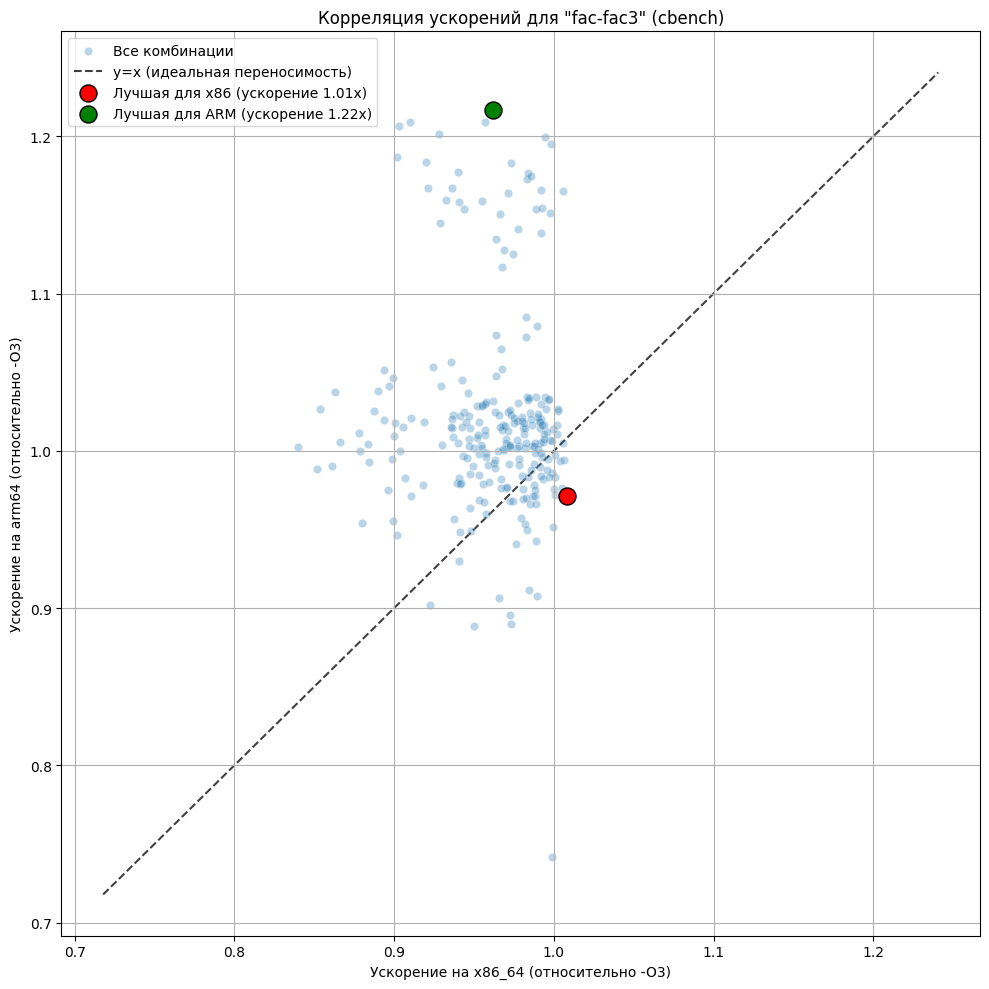


--- Анализ бенчмарка: fac-fac4 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 20.10% (Ускорение 1.0403x вместо 1.3020x)
    - Ранг лучшей x86-комбинации на ARM: 220 из 256
    - Перенос ARM -> x86: Потеря производительности 9.33% (Ускорение 0.9691x вместо 1.0688x)
    - Ранг лучшей ARM-комбинации на x86: 204 из 256


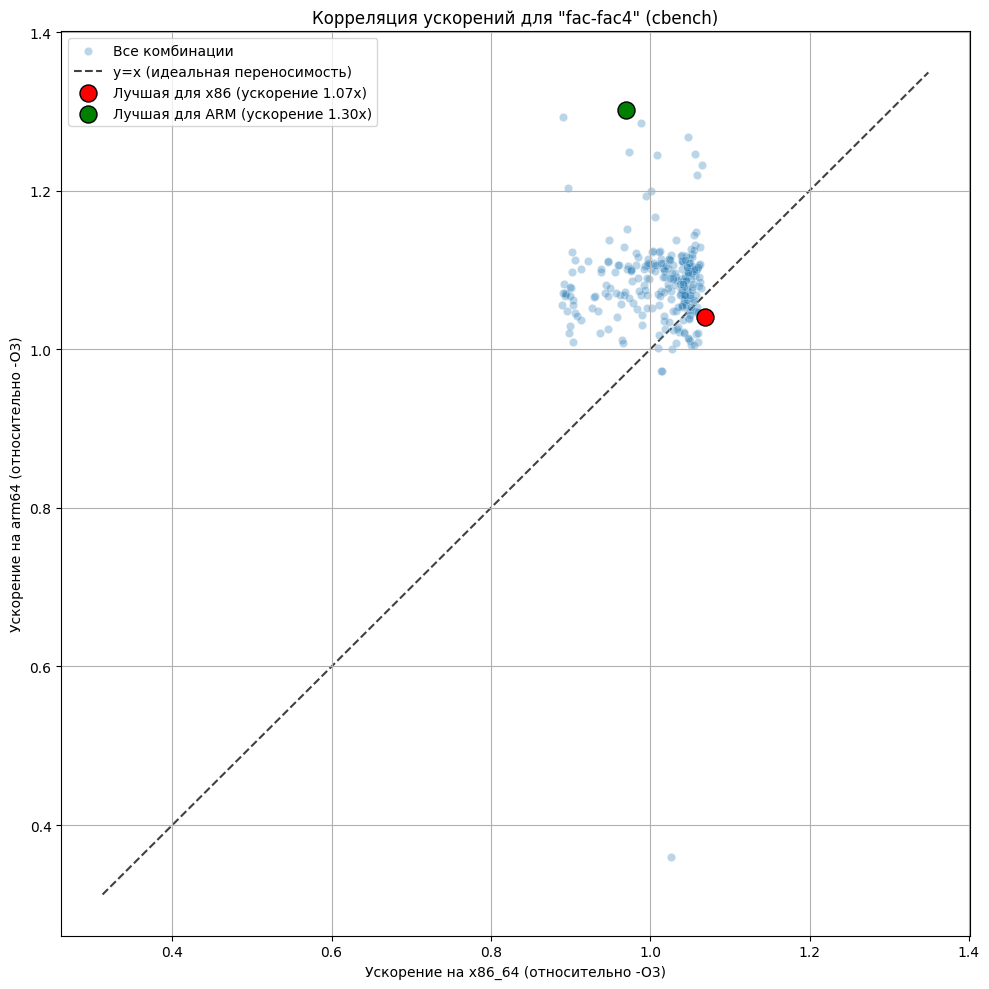


--- Анализ бенчмарка: fac-fac5 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 13.52% (Ускорение 1.0695x вместо 1.2368x)
    - Ранг лучшей x86-комбинации на ARM: 56 из 256
    - Перенос ARM -> x86: Потеря производительности 4.98% (Ускорение 0.9780x вместо 1.0293x)
    - Ранг лучшей ARM-комбинации на x86: 164 из 256


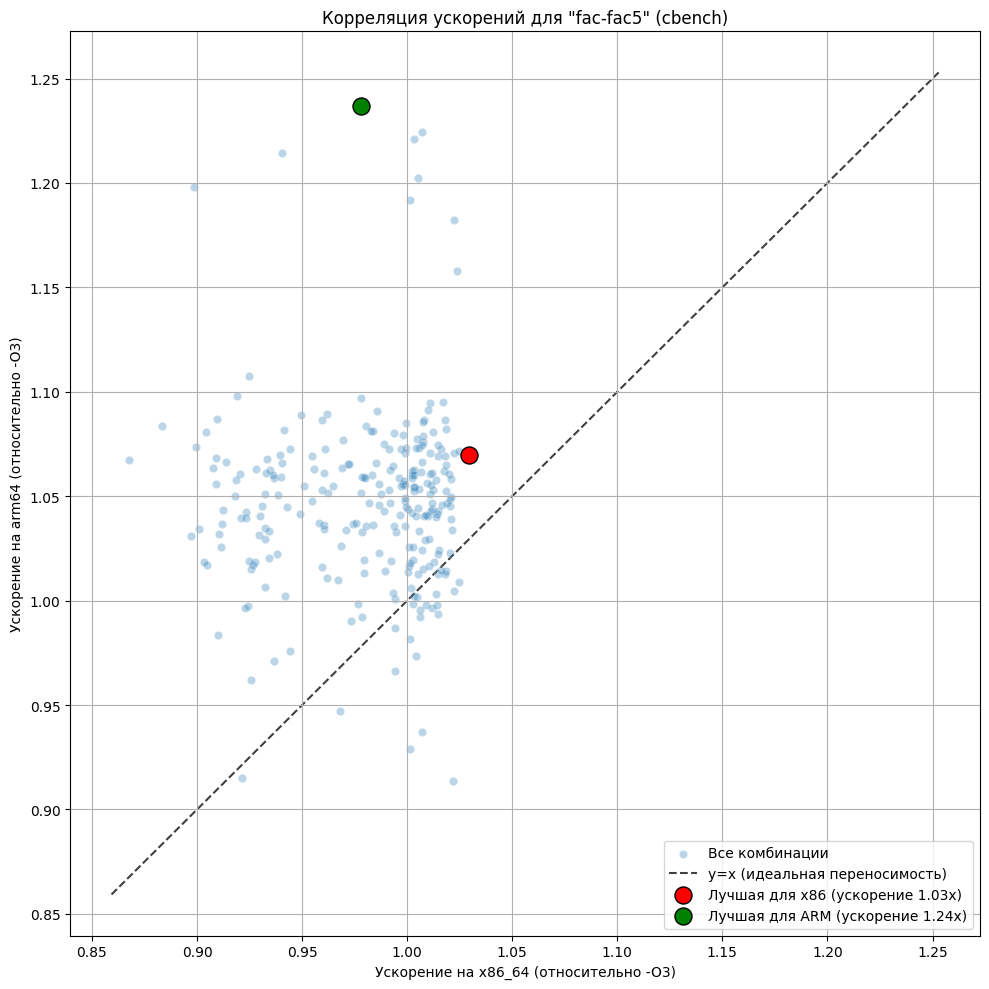


--- Анализ бенчмарка: fac-fac6 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 16.73% (Ускорение 1.0125x вместо 1.2159x)
    - Ранг лучшей x86-комбинации на ARM: 113 из 256
    - Перенос ARM -> x86: Потеря производительности 6.31% (Ускорение 0.9738x вместо 1.0394x)
    - Ранг лучшей ARM-комбинации на x86: 177 из 256


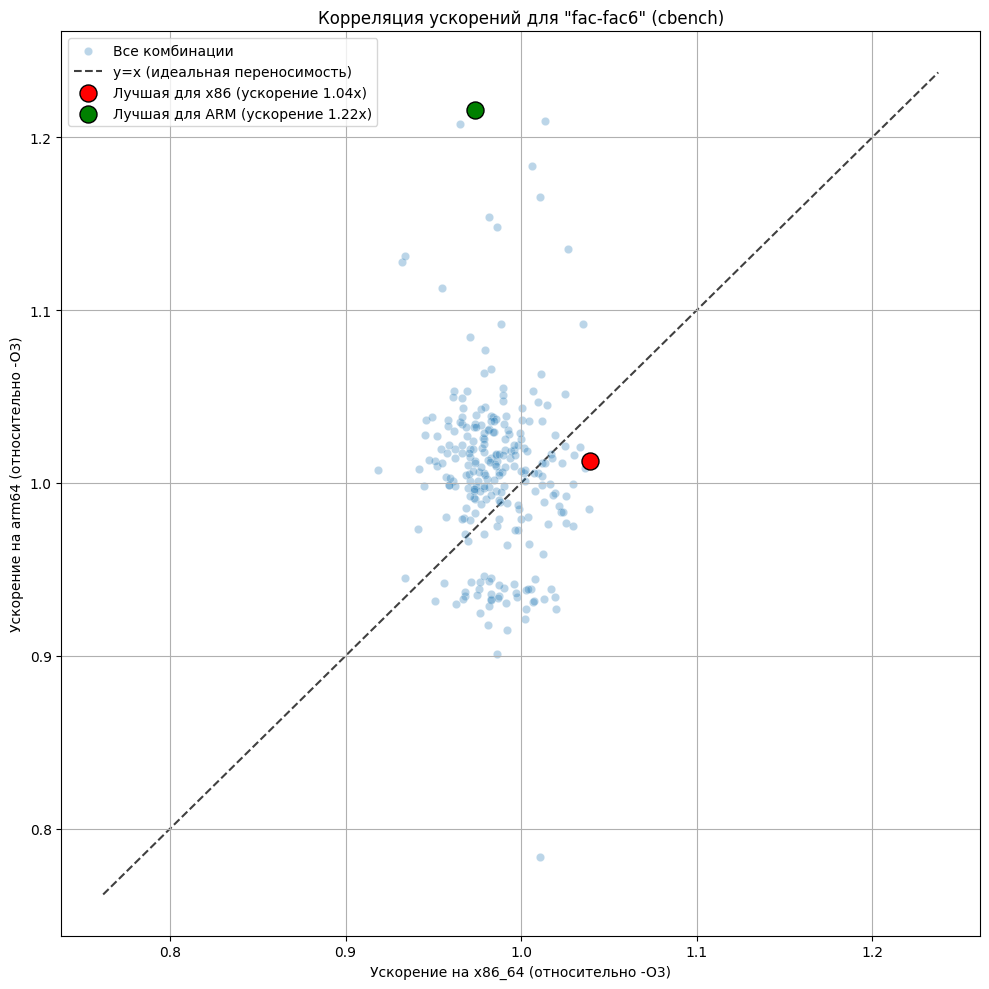


--- Анализ бенчмарка: fac-facx ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 20.78% (Ускорение 1.0276x вместо 1.2971x)
    - Ранг лучшей x86-комбинации на ARM: 239 из 256
    - Перенос ARM -> x86: Потеря производительности 1.79% (Ускорение 1.0038x вместо 1.0221x)
    - Ранг лучшей ARM-комбинации на x86: 62 из 256


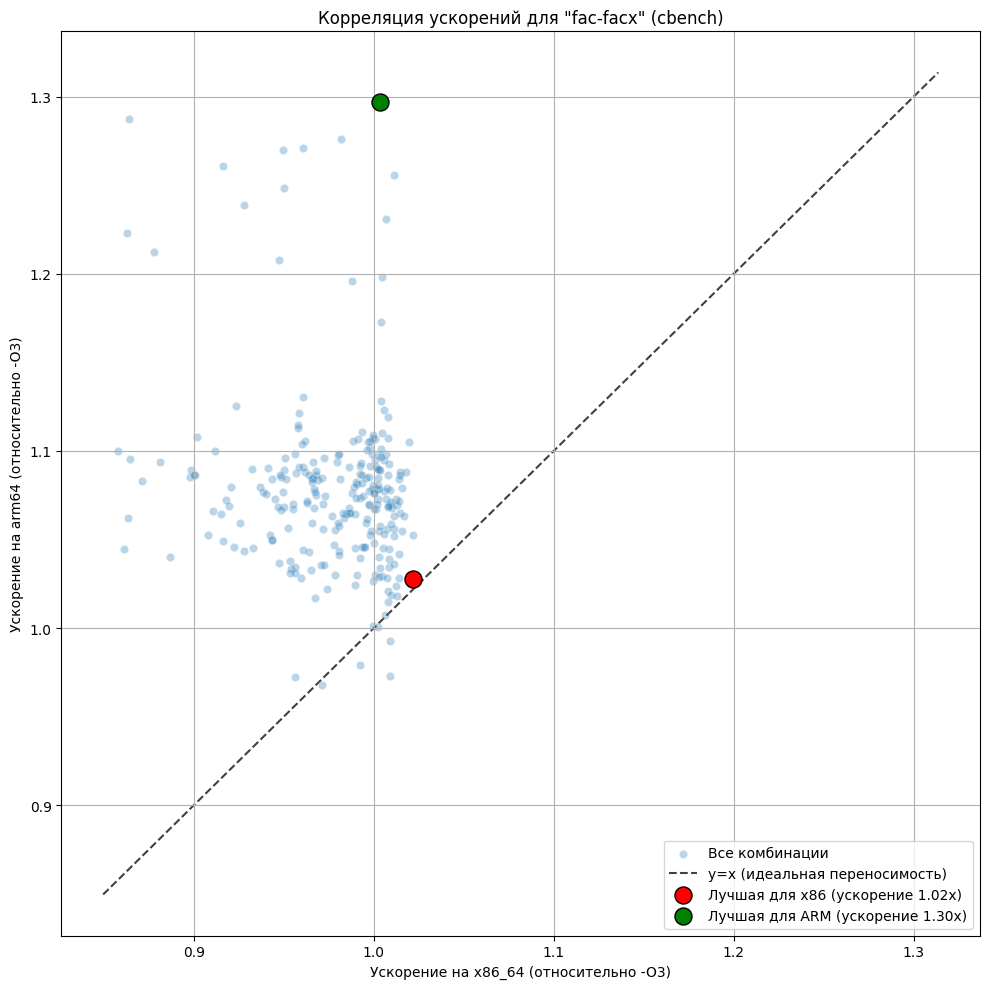


--- Анализ бенчмарка: fac-facy ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 18.27% (Ускорение 0.9707x вместо 1.1878x)
    - Ранг лучшей x86-комбинации на ARM: 179 из 256
    - Перенос ARM -> x86: Потеря производительности 3.32% (Ускорение 1.0161x вместо 1.0510x)
    - Ранг лучшей ARM-комбинации на x86: 141 из 256


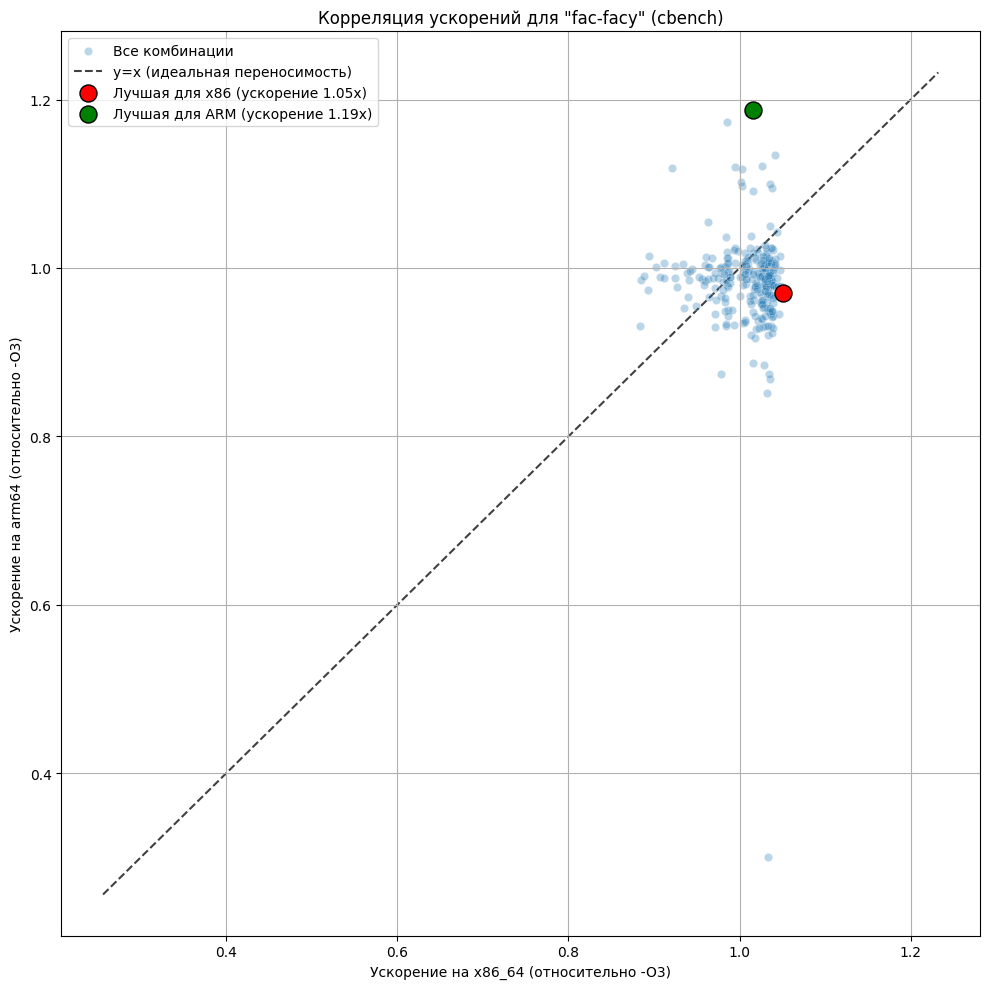


--- Анализ бенчмарка: malloc-malloc1 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 13.35% (Ускорение 0.9856x вместо 1.1374x)
    - Ранг лучшей x86-комбинации на ARM: 105 из 256
    - Перенос ARM -> x86: Потеря производительности 0.80% (Ускорение 0.9993x вместо 1.0075x)
    - Ранг лучшей ARM-комбинации на x86: 6 из 256


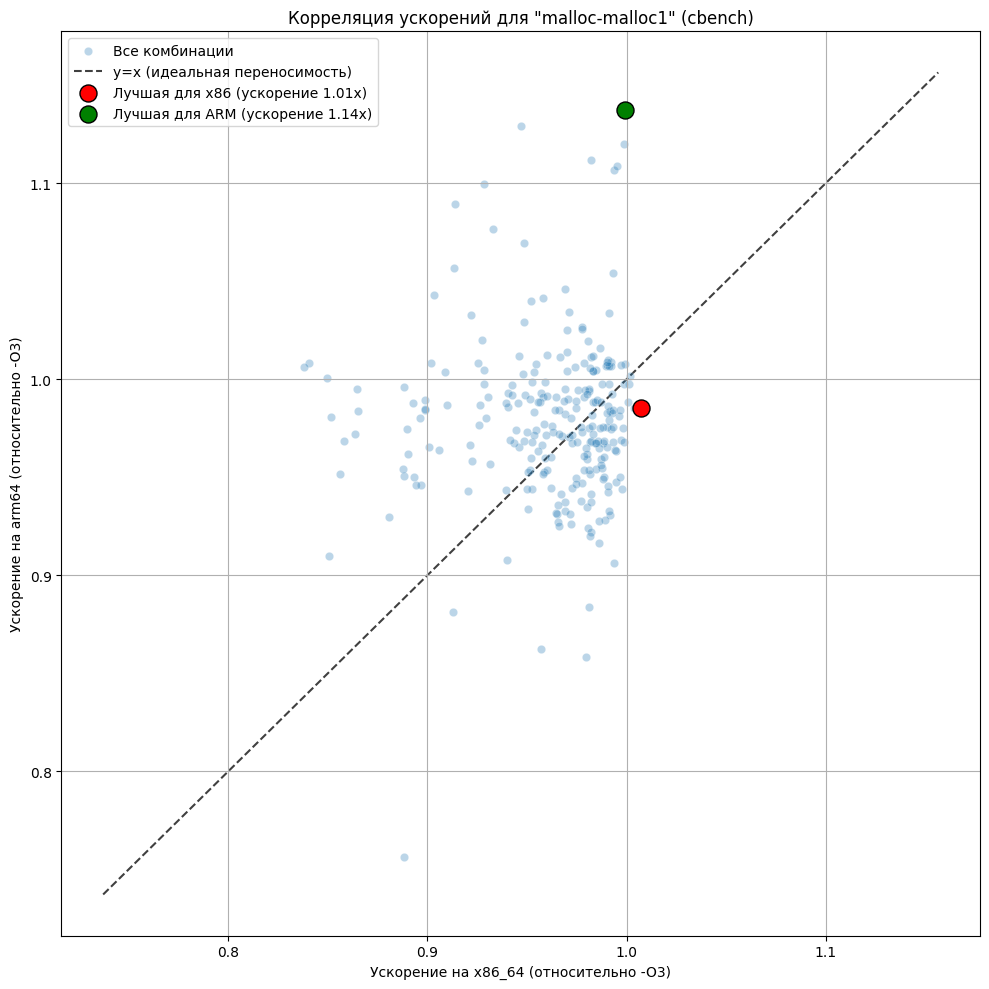


--- Анализ бенчмарка: malloc-malloc2 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 15.94% (Ускорение 0.9974x вместо 1.1865x)
    - Ранг лучшей x86-комбинации на ARM: 156 из 256
    - Перенос ARM -> x86: Потеря производительности 0.67% (Ускорение 1.0293x вместо 1.0362x)
    - Ранг лучшей ARM-комбинации на x86: 9 из 256


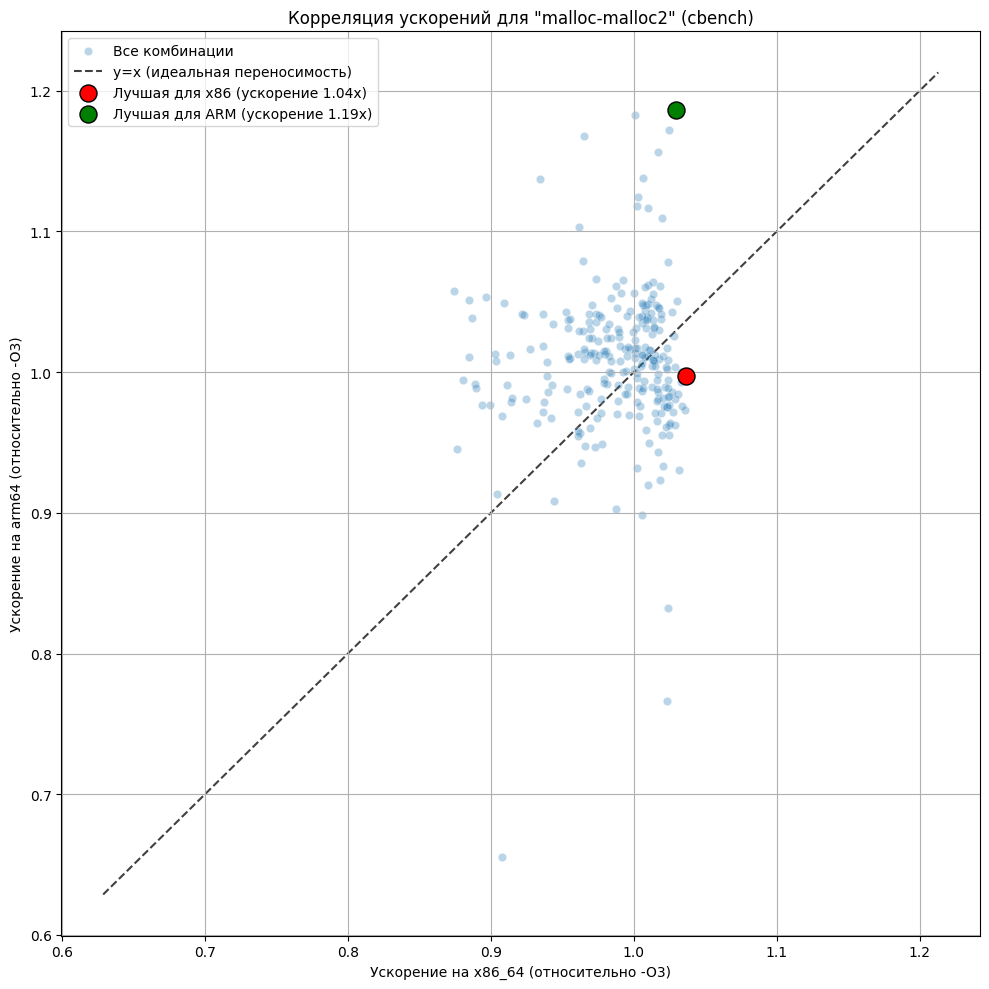


--- Анализ бенчмарка: malloc-malloc3 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 13.43% (Ускорение 1.0112x вместо 1.1681x)
    - Ранг лучшей x86-комбинации на ARM: 99 из 256
    - Перенос ARM -> x86: Потеря производительности 1.93% (Ускорение 0.9910x вместо 1.0106x)
    - Ранг лучшей ARM-комбинации на x86: 58 из 256


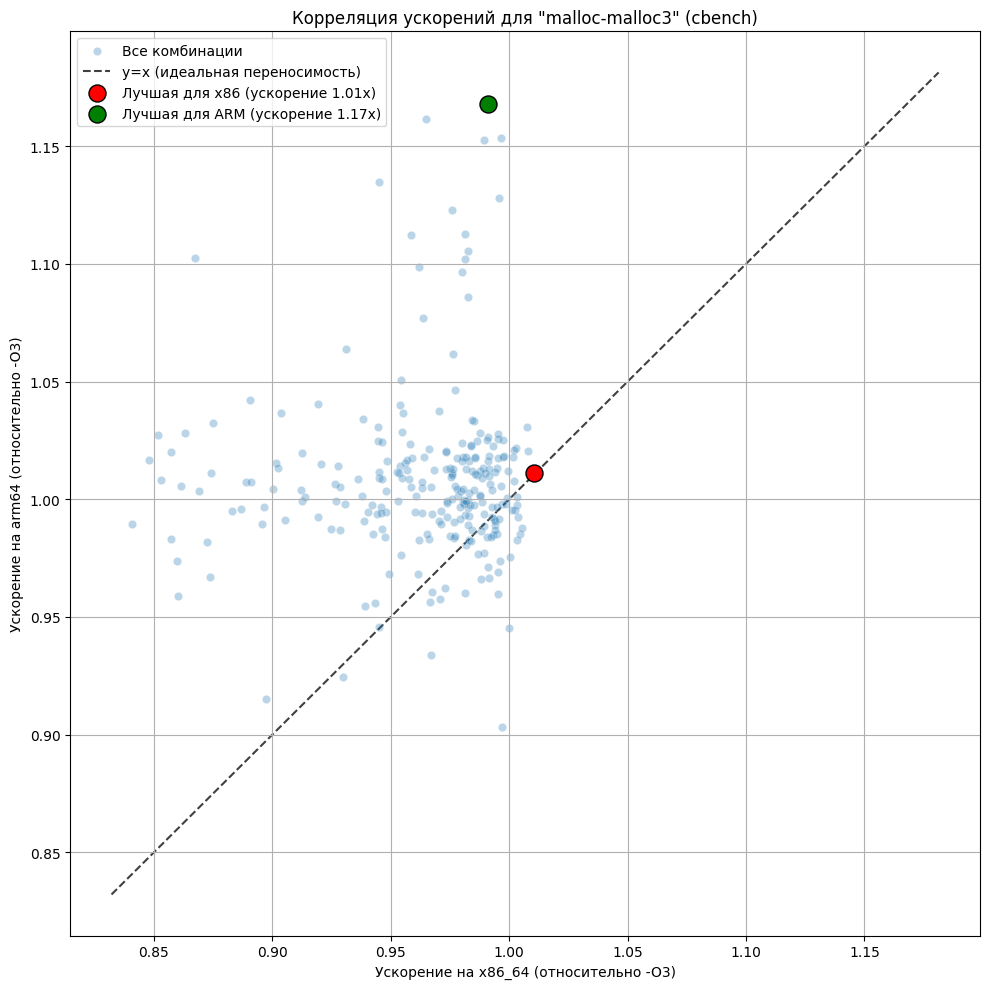


--- Анализ бенчмарка: malloc-malloc4 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 10.83% (Ускорение 1.0496x вместо 1.1770x)
    - Ранг лучшей x86-комбинации на ARM: 49 из 256
    - Перенос ARM -> x86: Потеря производительности 1.35% (Ускорение 1.0240x вместо 1.0381x)
    - Ранг лучшей ARM-комбинации на x86: 36 из 256


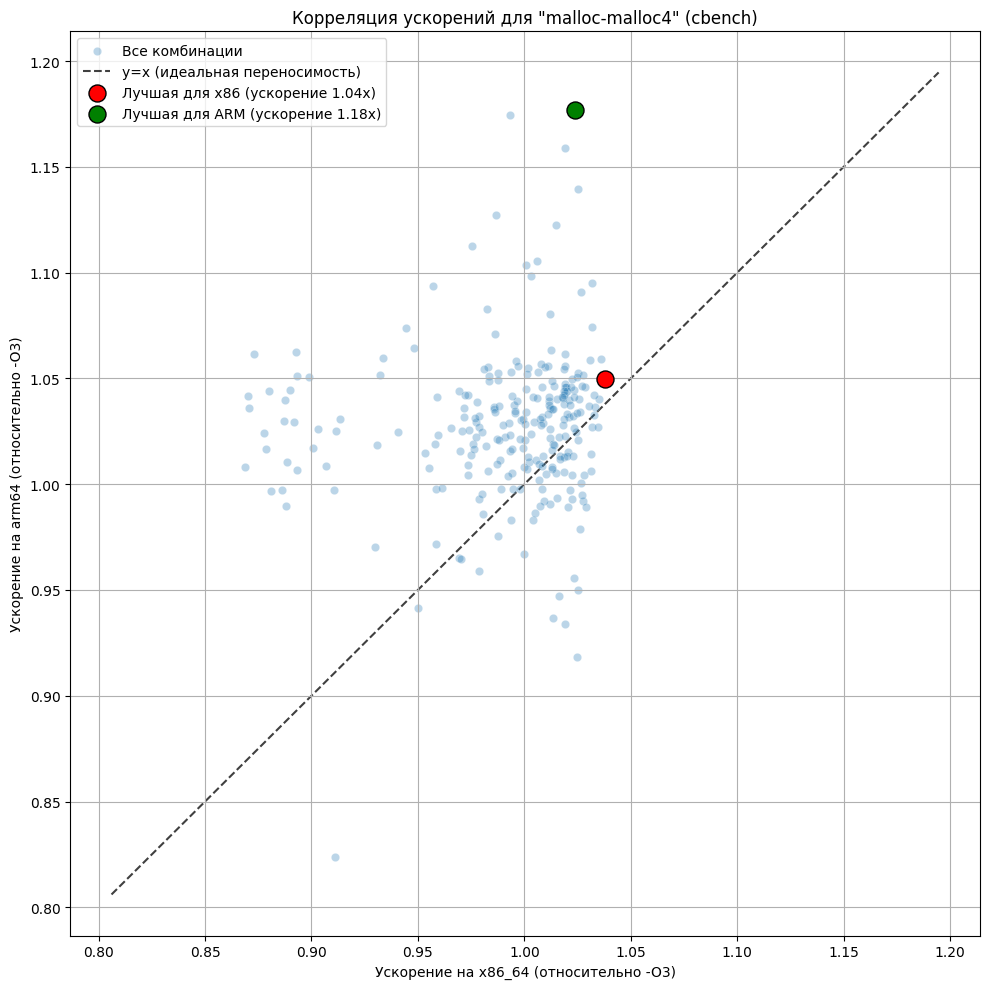


--- Анализ бенчмарка: qsort-qsort1 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 18.14% (Ускорение 0.9899x вместо 1.2092x)
    - Ранг лучшей x86-комбинации на ARM: 216 из 256
    - Перенос ARM -> x86: Потеря производительности 3.94% (Ускорение 1.0238x вместо 1.0657x)
    - Ранг лучшей ARM-комбинации на x86: 11 из 256


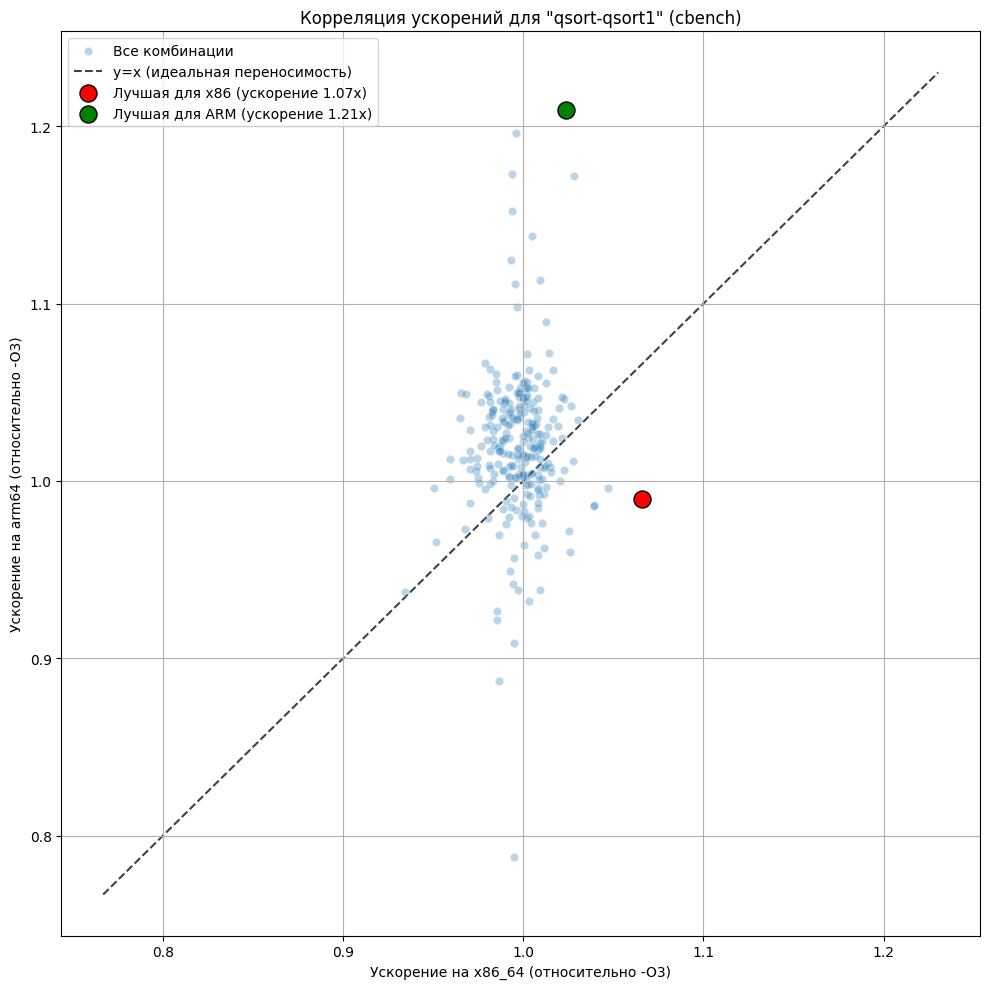


--- Анализ бенчмарка: qsort-qsort2 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 13.92% (Ускорение 0.9782x вместо 1.1364x)
    - Ранг лучшей x86-комбинации на ARM: 113 из 256
    - Перенос ARM -> x86: Потеря производительности 6.15% (Ускорение 0.9884x вместо 1.0532x)
    - Ранг лучшей ARM-комбинации на x86: 189 из 256


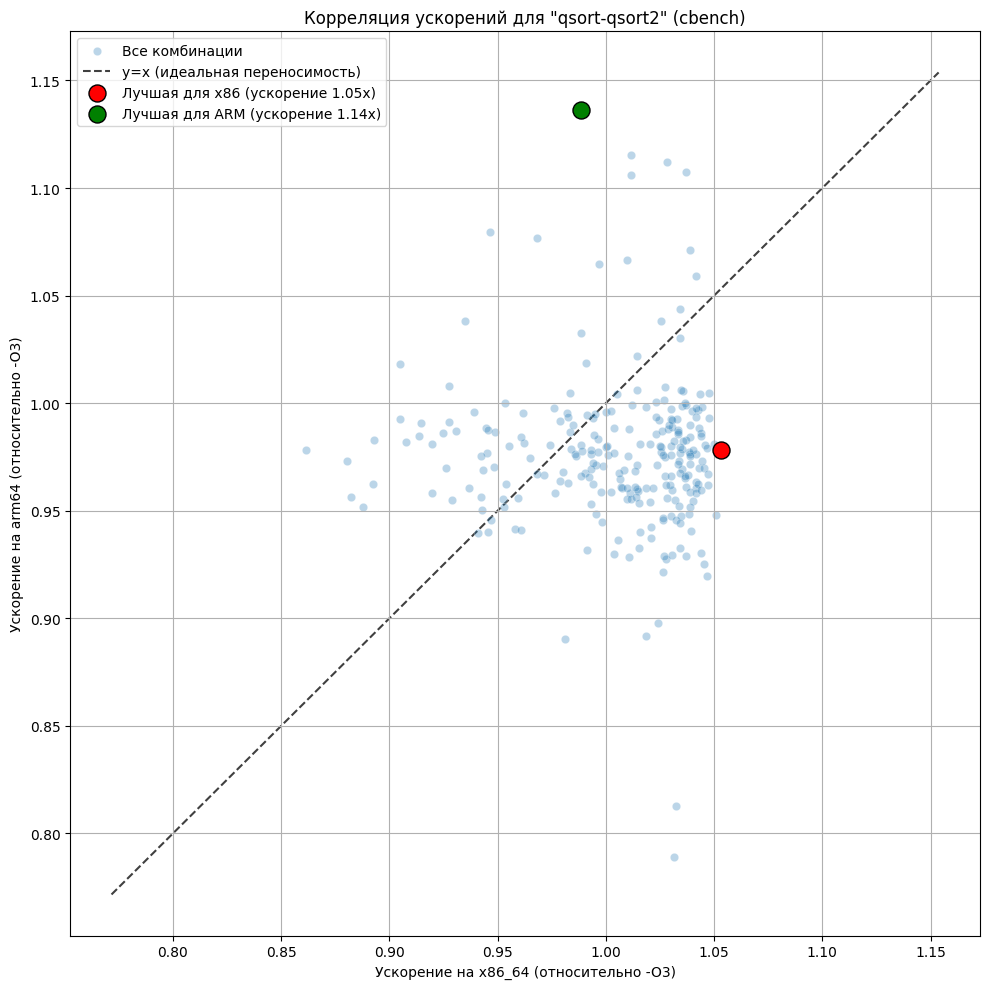


--- Анализ бенчмарка: qsort-qsort3 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 14.39% (Ускорение 0.9940x вместо 1.1610x)
    - Ранг лучшей x86-комбинации на ARM: 98 из 256
    - Перенос ARM -> x86: Потеря производительности 1.95% (Ускорение 1.0113x вместо 1.0315x)
    - Ранг лучшей ARM-комбинации на x86: 57 из 256


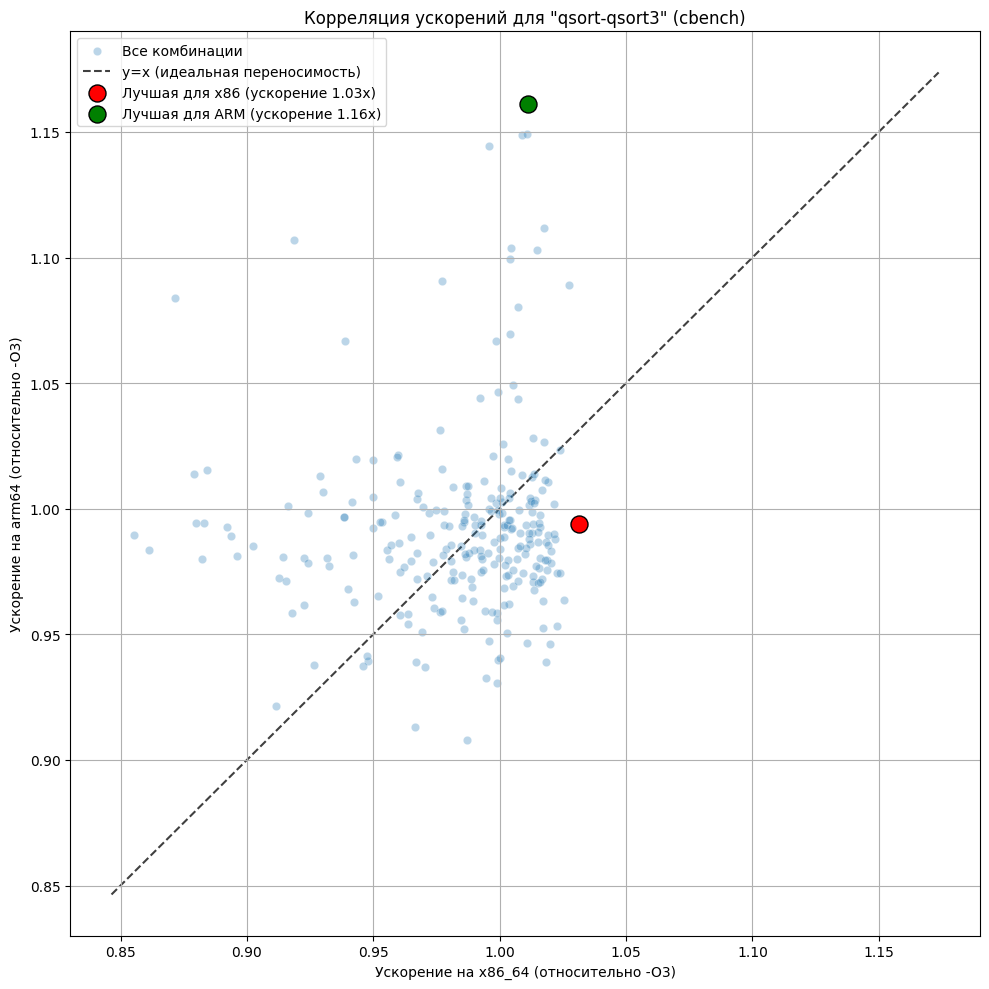


--- Анализ бенчмарка: qsort-qsort4 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 17.33% (Ускорение 0.9615x вместо 1.1630x)
    - Ранг лучшей x86-комбинации на ARM: 219 из 256
    - Перенос ARM -> x86: Потеря производительности 3.25% (Ускорение 0.9766x вместо 1.0094x)
    - Ранг лучшей ARM-комбинации на x86: 113 из 256


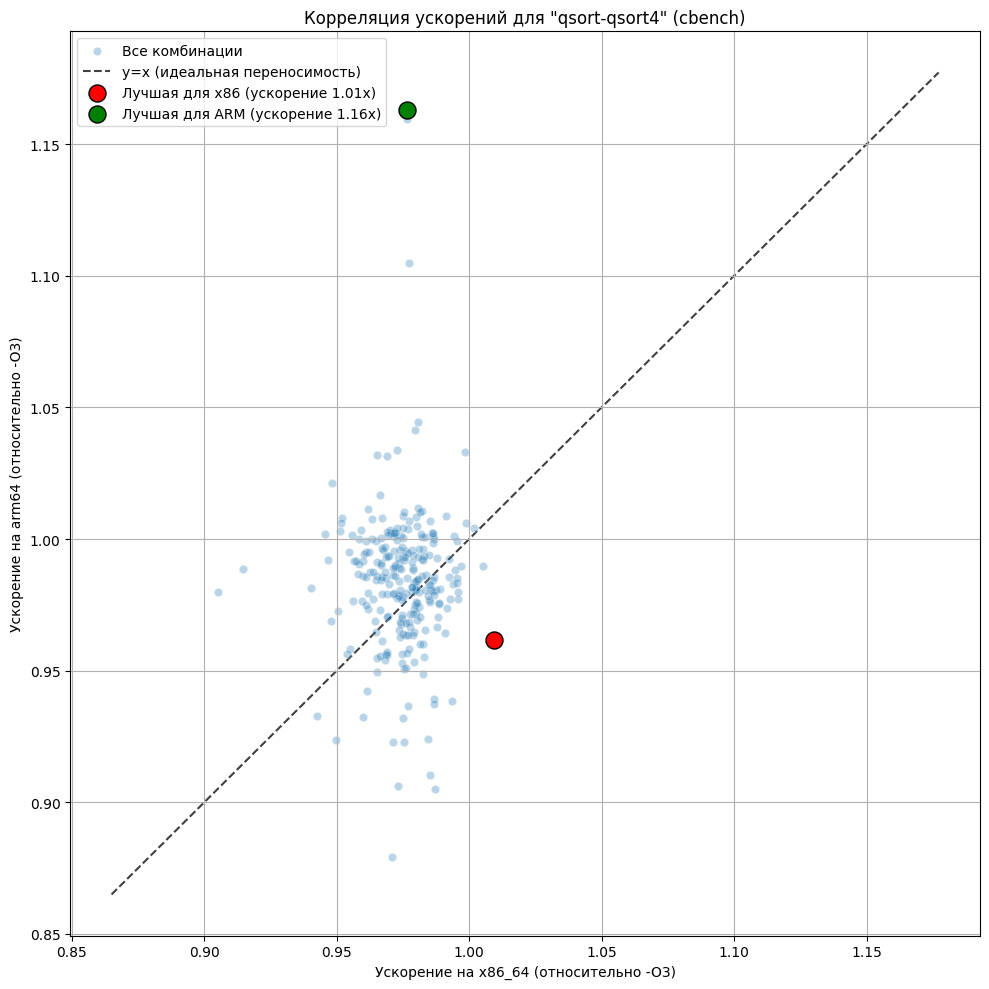


--- Анализ бенчмарка: qsort-qsort5 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 1.55% (Ускорение 1.0030x вместо 1.0189x)
    - Ранг лучшей x86-комбинации на ARM: 105 из 256
    - Перенос ARM -> x86: Потеря производительности 1.52% (Ускорение 0.9962x вместо 1.0115x)
    - Ранг лучшей ARM-комбинации на x86: 93 из 256


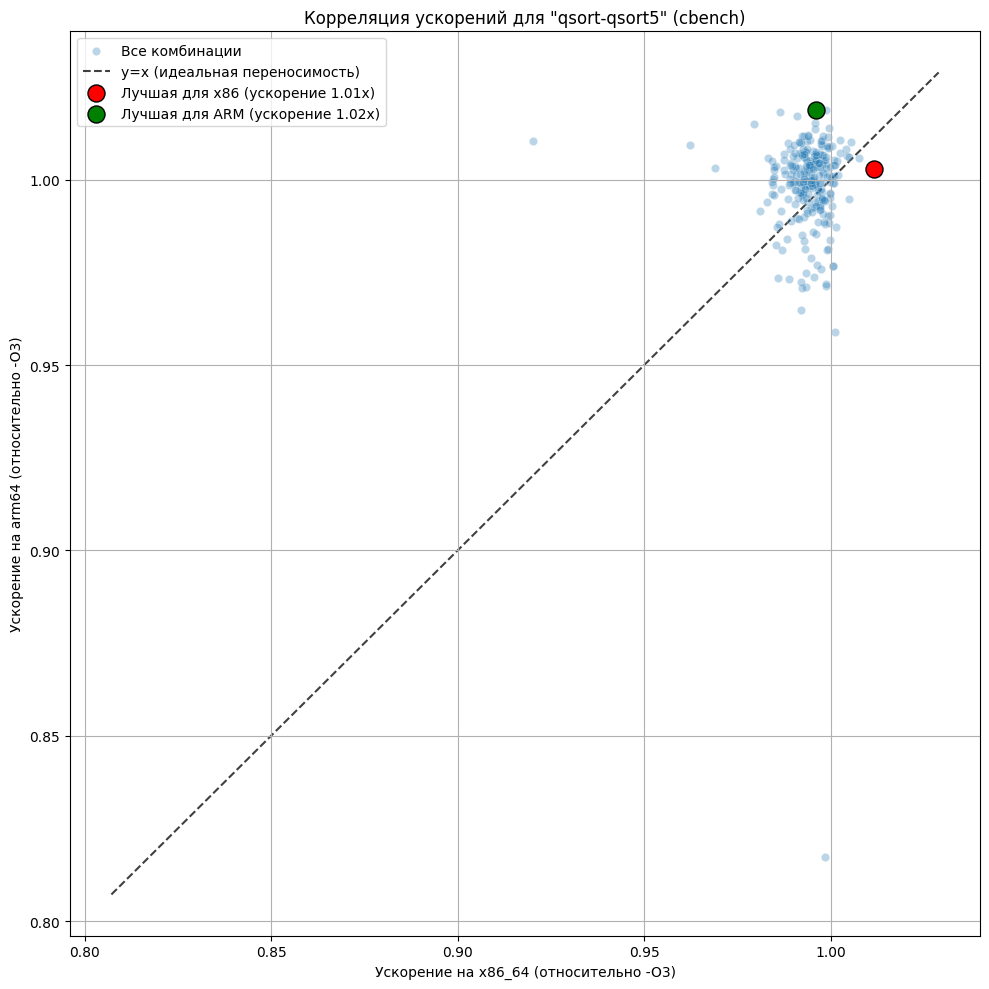


--- Анализ бенчмарка: sqrt-sqrt1 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 1.39% (Ускорение 1.0058x вместо 1.0199x)
    - Ранг лучшей x86-комбинации на ARM: 57 из 256
    - Перенос ARM -> x86: Потеря производительности 1.90% (Ускорение 1.0665x вместо 1.0871x)
    - Ранг лучшей ARM-комбинации на x86: 106 из 256


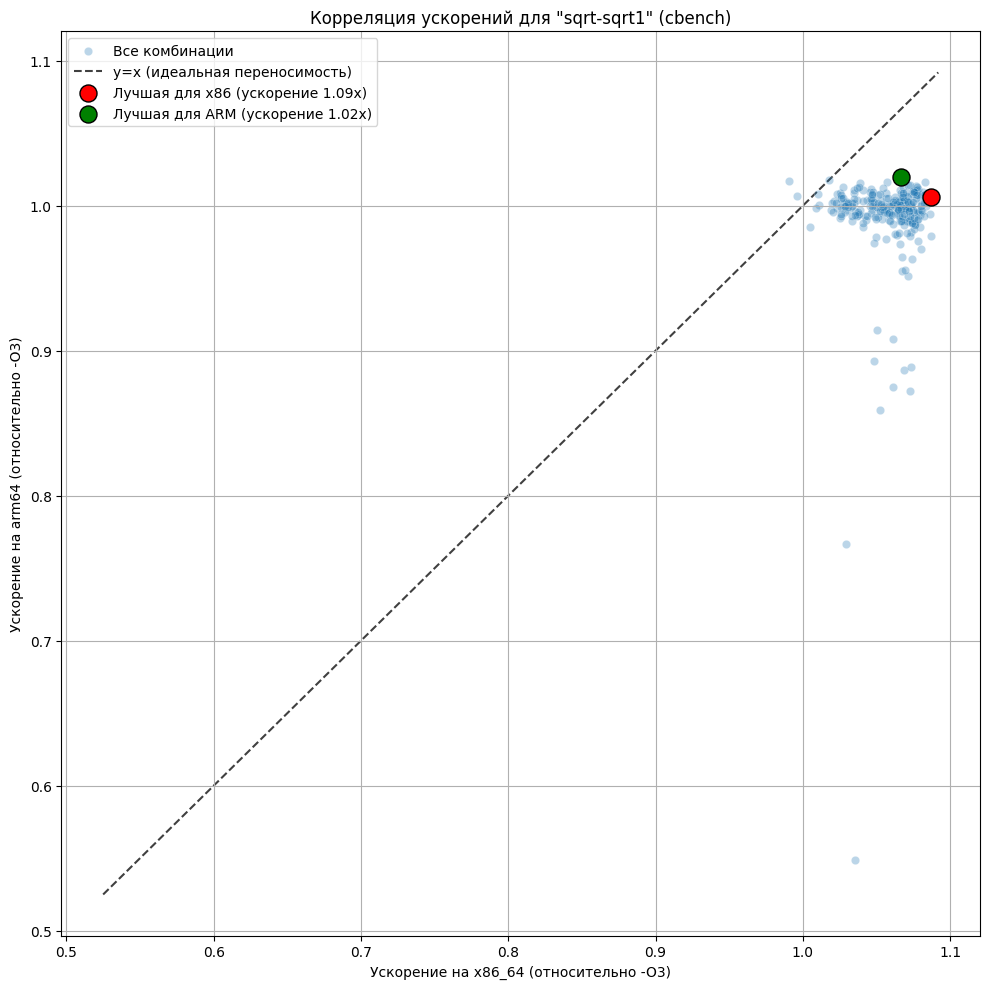


--- Анализ бенчмарка: sqrt-sqrt2 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 12.03% (Ускорение 1.0345x вместо 1.1761x)
    - Ранг лучшей x86-комбинации на ARM: 15 из 256
    - Перенос ARM -> x86: Потеря производительности 11.57% (Ускорение 0.9174x вместо 1.0374x)
    - Ранг лучшей ARM-комбинации на x86: 225 из 256


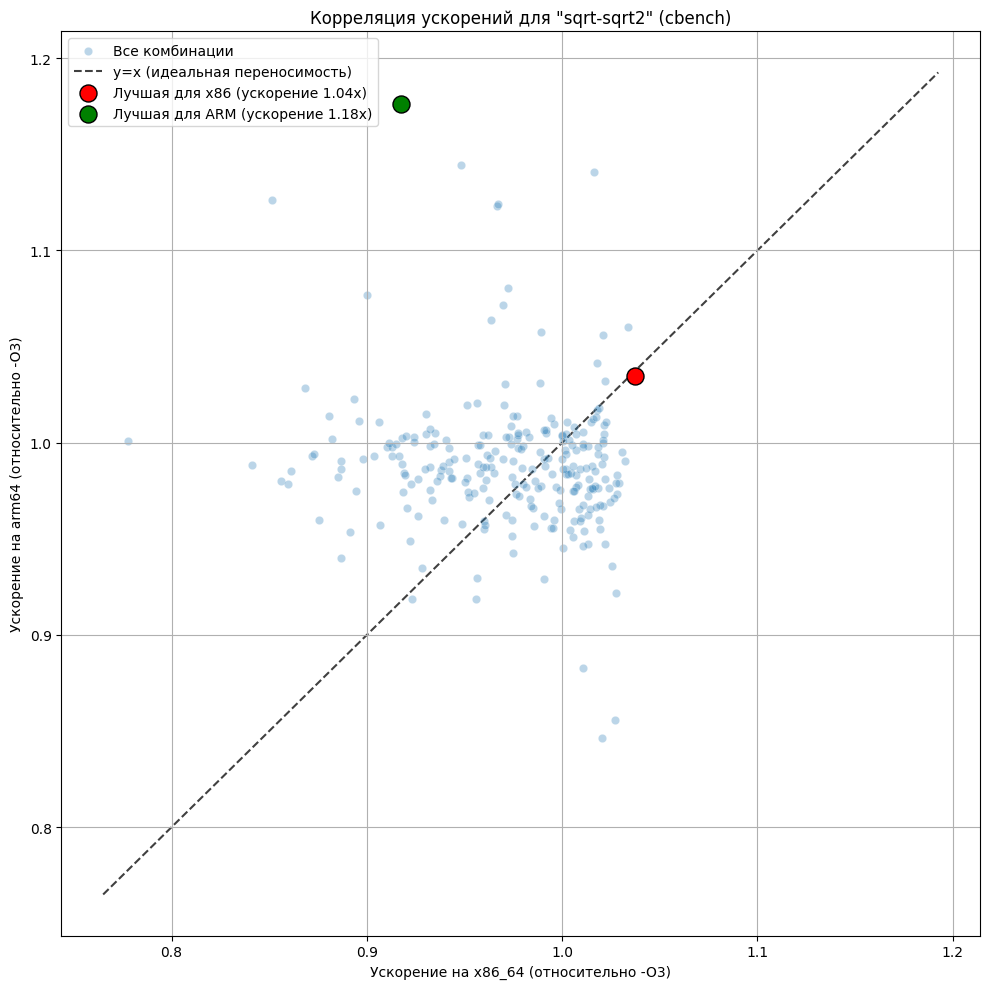


--- Анализ бенчмарка: sqrt-sqrt3 ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 15.33% (Ускорение 0.9902x вместо 1.1695x)
    - Ранг лучшей x86-комбинации на ARM: 118 из 256
    - Перенос ARM -> x86: Потеря производительности 3.54% (Ускорение 1.0122x вместо 1.0494x)
    - Ранг лучшей ARM-комбинации на x86: 108 из 256


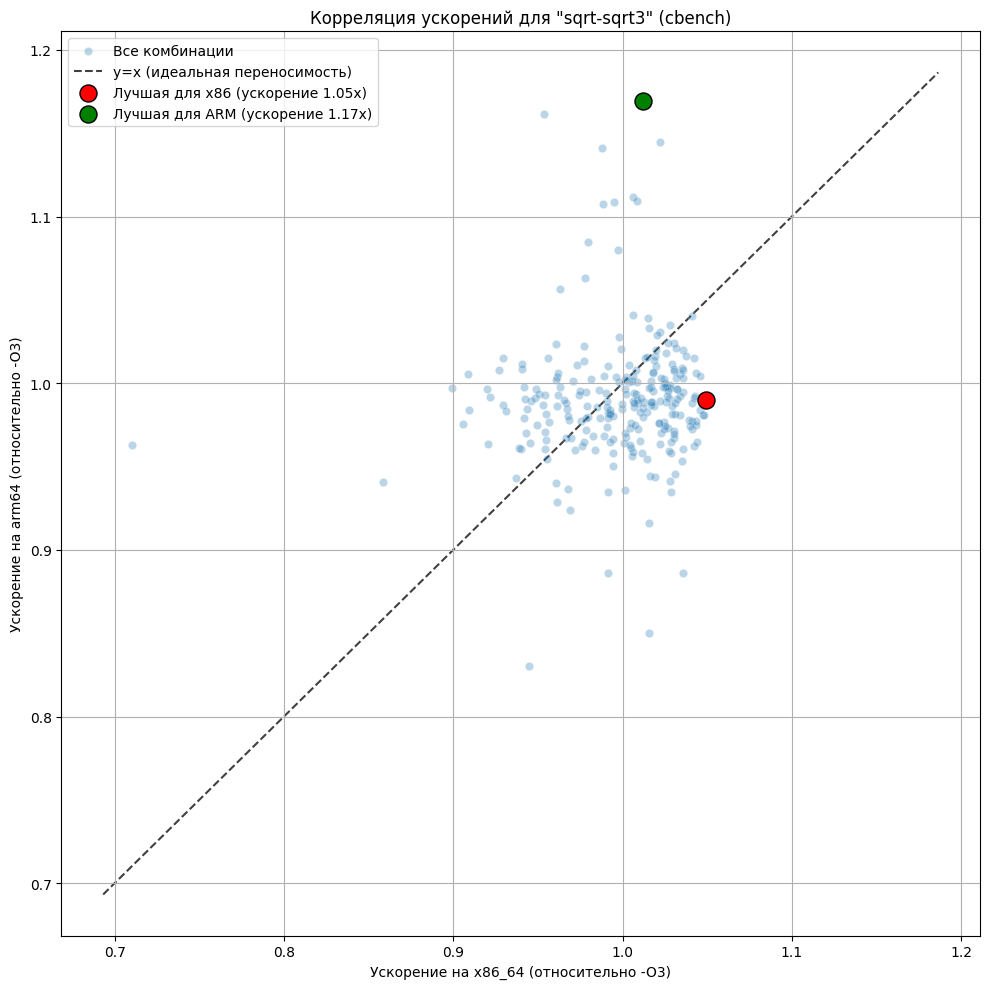


--- Итоги по набору CBENCH ---
Всего проанализировано бенчмарков: 23
Количество полных совпадений оптимальных флагов: 0 (0.0%)
Вывод: Гипотеза о непереносимости в целом ПОДТВЕРЖДАЕТСЯ.
Графики сохранены в директорию 'plots/'.

==================== АНАЛИЗ НАБОРА: MIBENCH ====================

--- Анализ бенчмарка: automotive_basicmath ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 1.49% (Ускорение 0.9981x вместо 1.0132x)
    - Ранг лучшей x86-комбинации на ARM: 39 из 256
    - Перенос ARM -> x86: Потеря производительности 3.44% (Ускорение 1.0049x вместо 1.0407x)
    - Ранг лучшей ARM-комбинации на x86: 106 из 256


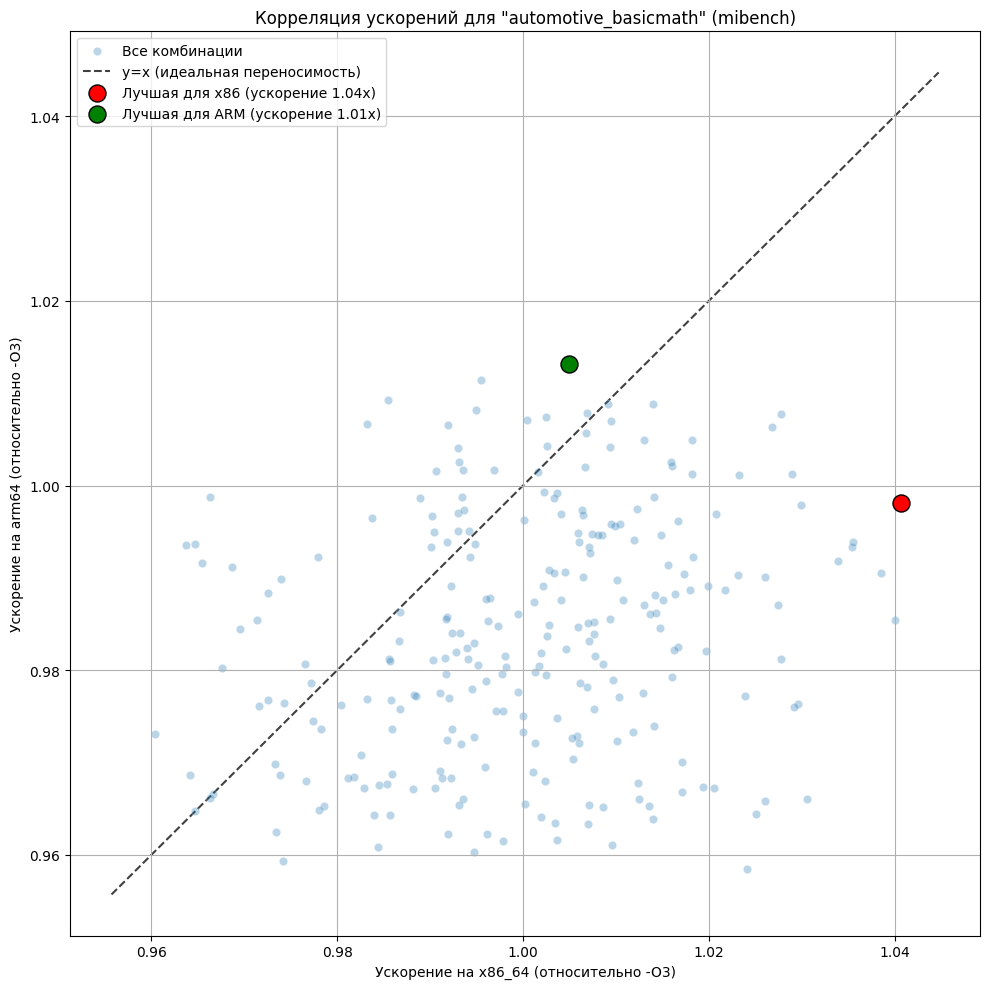


--- Анализ бенчмарка: automotive_bitcount ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 1.18% (Ускорение 1.0917x вместо 1.1047x)
    - Ранг лучшей x86-комбинации на ARM: 78 из 256
    - Перенос ARM -> x86: Потеря производительности 8.99% (Ускорение 1.2566x вместо 1.3807x)
    - Ранг лучшей ARM-комбинации на x86: 95 из 256


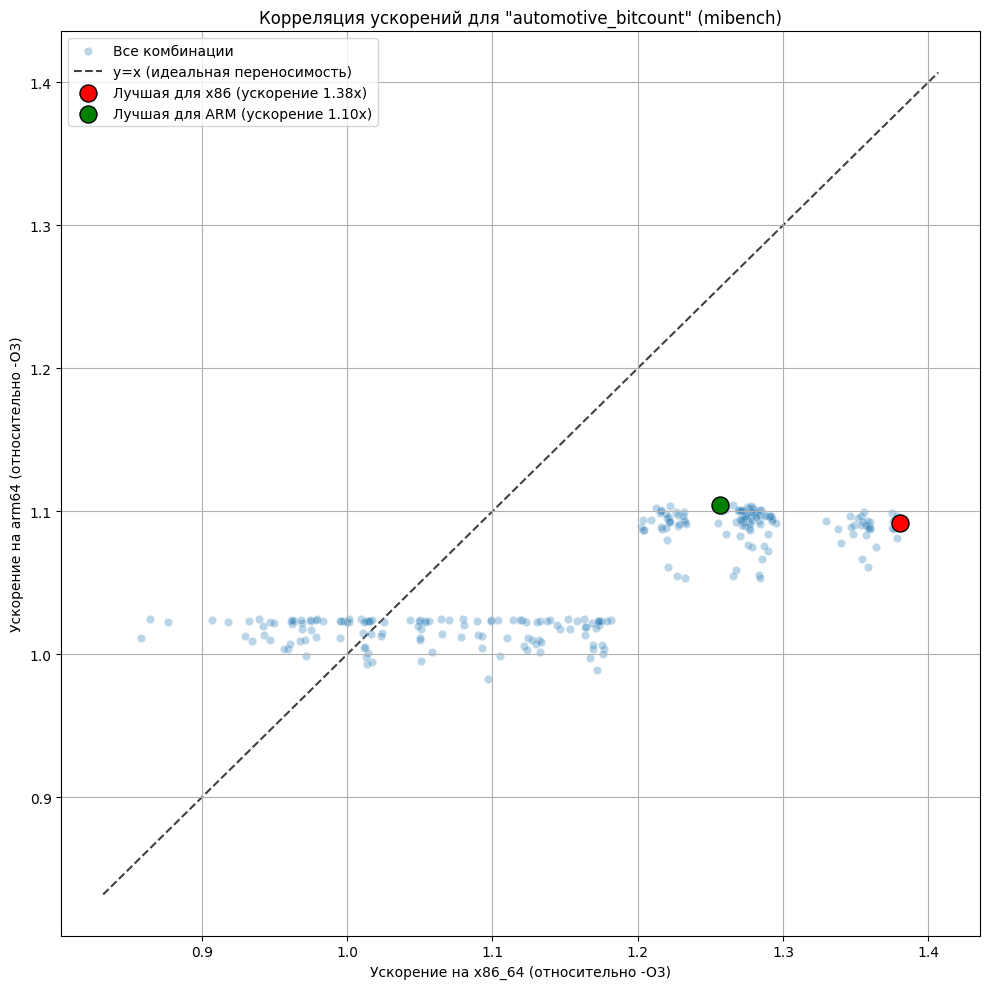


--- Анализ бенчмарка: automotive_susan_s ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 0.22% (Ускорение 1.2030x вместо 1.2057x)
    - Ранг лучшей x86-комбинации на ARM: 33 из 256
    - Перенос ARM -> x86: Потеря производительности 2.14% (Ускорение 1.2611x вместо 1.2887x)
    - Ранг лучшей ARM-комбинации на x86: 33 из 256


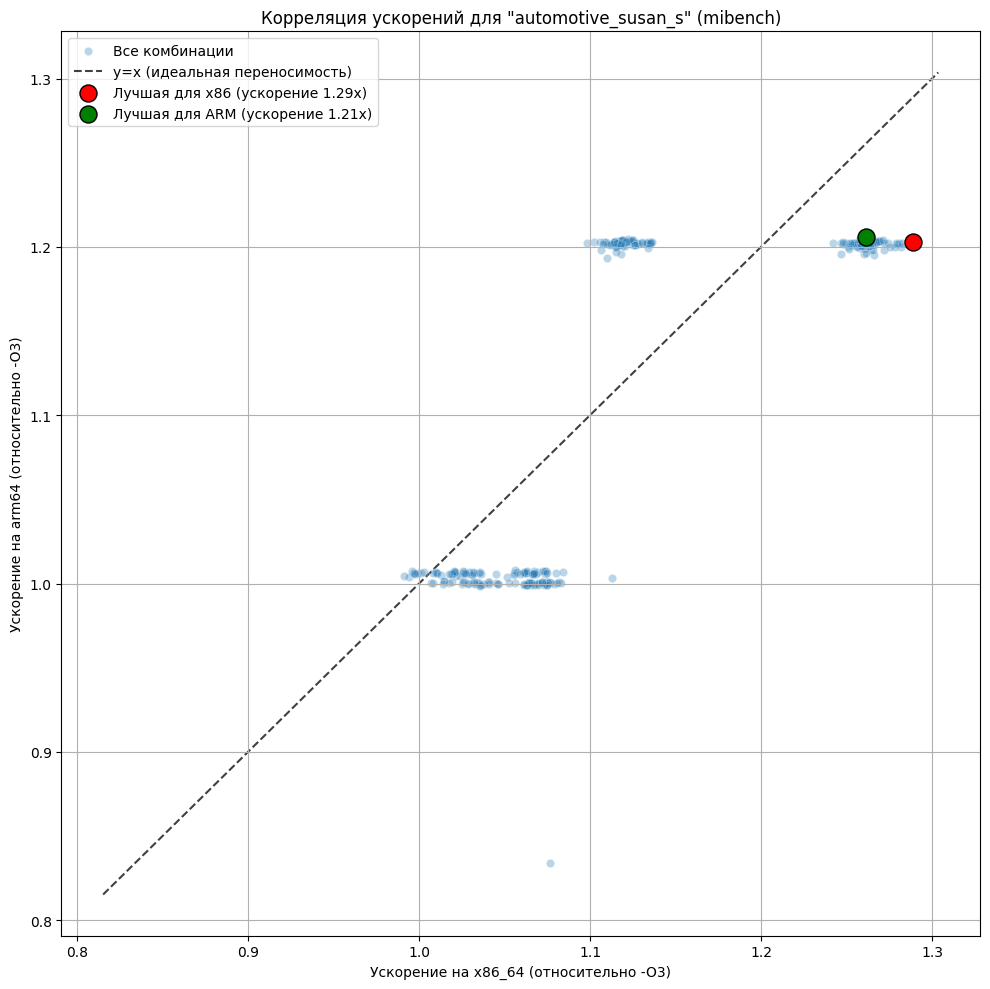


--- Анализ бенчмарка: network_dijkstra ---
  [-] Оптимальные комбинации флагов РАЗЛИЧАЮТСЯ.
    - Перенос x86 -> ARM: Потеря производительности 0.17% (Ускорение 1.0039x вместо 1.0057x)
    - Ранг лучшей x86-комбинации на ARM: 12 из 256
    - Перенос ARM -> x86: Потеря производительности 1.62% (Ускорение 1.0479x вместо 1.0651x)
    - Ранг лучшей ARM-комбинации на x86: 16 из 256


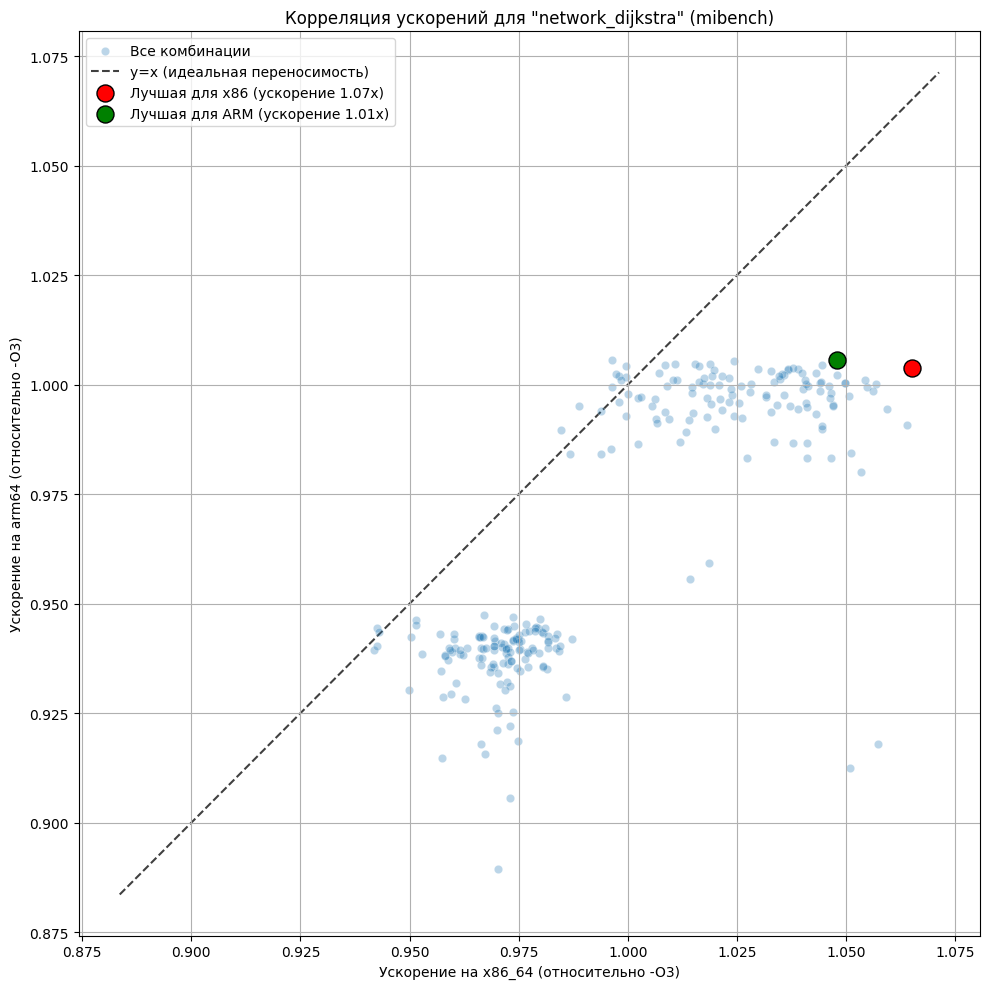


--- Итоги по набору MIBENCH ---
Всего проанализировано бенчмарков: 4
Количество полных совпадений оптимальных флагов: 0 (0.0%)
Вывод: Гипотеза о непереносимости в целом ПОДТВЕРЖДАЕТСЯ.
Графики сохранены в директорию 'plots/'.


In [15]:
for suite_name, files in FILE_PAIRS.items():
    analyze_suite(suite_name, files)